In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers==4.37.2
!pip install "pandas<2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [3]:
import os
import pickle
import itertools

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


from tensorflow import keras
from glob import glob
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model


In [4]:
%matplotlib inline

In [5]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

In [6]:
# brendanho123
data_path = 'drive/My Drive/Colab Notebooks/W266/Final Project/data'

# bho1
# data_path = 'drive/My Drive/Colab Notebooks/Final Project/data'

# bholly597
# data_path = 'drive/My Drive/Final Project/data'

In [7]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [8]:
unpickled_data = {}

keys_to_unpickle = [
    'train_data',
    'test_data',
    'val_data',
]


for key in keys_to_unpickle:
    filename = f'{data_path}/cleaned_data/{key}.pkl'
    with open(filename, 'rb') as file:
        unpickled_data[key] = pickle.load(file)


train_data = unpickled_data['train_data']
test_data = unpickled_data['test_data']
val_data = unpickled_data['val_data']


In [9]:
MAX_SEQUENCE_LENGTH = 128                 # set max_length of the input sequence

# num_train_examples = 2000
# num_val_examples = 200


num_train_examples = 10000
num_val_examples = 1000


# num_train_examples = 50000
# num_val_examples = 5000

# num_train_examples = train_data.shape[0]
# num_val_examples = test_data.shape[0]


In [10]:
x_train_file_path = f'{data_path}/tokens/x_train_tokens_{num_train_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
x_val_file_path = f'{data_path}/tokens/x_val_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
x_test_file_path = f'{data_path}/tokens/x_test_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'

# Get train data
if os.path.exists(x_train_file_path):
  x_train = pickle.load(open(x_train_file_path, 'rb'))
else:
  x_train = bert_tokenizer(list(train_data['text'])[:num_train_examples],
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')


  with open(x_train_file_path, 'wb') as f:
    pickle.dump(x_train, f)

# Get val data
if os.path.exists(x_val_file_path):
  x_val = pickle.load(open(x_val_file_path, 'rb'))
else:
  x_val = bert_tokenizer(list(val_data['text'])[:num_val_examples],
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

  with open(x_val_file_path, 'wb') as f:
    pickle.dump(x_val, f)

# Get test data
if os.path.exists(x_test_file_path):
  x_test = pickle.load(open(x_test_file_path, 'rb'))
else:
  x_test = bert_tokenizer(list(test_data['text'])[:num_val_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')

  with open(x_test_file_path, 'wb') as f:
    pickle.dump(x_test, f)


y_train = train_data['Overall_score'][:num_train_examples]
y_val = val_data['Overall_score'][:num_val_examples]
y_test = test_data['Overall_score'][:num_val_examples]


In [11]:
# Experiment 2 UIDs specifics here

anime_features_train = train_data['anime_uid'][:num_train_examples]
anime_features_val = val_data['anime_uid'][:num_val_examples]
anime_features_test = test_data['anime_uid'][:num_val_examples]

user_features_train = train_data['profile_uid'][:num_train_examples]
user_features_val = val_data['profile_uid'][:num_val_examples]
user_features_test = test_data['profile_uid'][:num_val_examples]

In [12]:

train_synopsis_file_path = f'{data_path}/tokens/train_synopsis_tokens_{num_train_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
val_synopsis_file_path = f'{data_path}/tokens/val_synopsis_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
test_synopsis_file_path = f'{data_path}/tokens/test_synopsis_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'

if os.path.exists(train_synopsis_file_path):
  bert_train_synopsis = pickle.load(open(train_synopsis_file_path, 'rb'))
else:
  train_synopsis = train_data['synopsis'].astype(str).tolist()
  bert_train_synopsis = bert_tokenizer(train_synopsis[:num_train_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  with open(train_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_train_synopsis, f)

if os.path.exists(val_synopsis_file_path):
  bert_val_synopsis = pickle.load(open(val_synopsis_file_path, 'rb'))
else:
  val_synopsis = test_data['synopsis'].astype(str).tolist()
  bert_val_synopsis = bert_tokenizer(val_synopsis[:num_val_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  with open(val_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_val_synopsis, f)

if os.path.exists(test_synopsis_file_path):
  bert_test_synopsis = pickle.load(open(test_synopsis_file_path, 'rb'))
else:
  test_synopsis = test_data['synopsis'].astype(str).tolist()
  bert_test_synopsis = bert_tokenizer(test_synopsis[:num_val_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  with open(test_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_test_synopsis, f)

### Model

In [13]:
# Experiment 2
all_data = pd.concat([train_data[:num_train_examples], val_data[:num_val_examples], test_data[:num_val_examples]])

num_animes = len(all_data['anime_uid'].unique())
num_users = len(all_data['profile_uid'].unique())

In [14]:
def create_two_tower_model(
    bert_model,
    train_layers=True,
    layers=[70, 50, 20, 10],
    dropout=0.3,
    optimizer_type='adam',
    learning_rate=0.00005,
    loss='mean_absolute_error',
    embedding_size=10, ################### Experiment 2
):

    if not train_layers:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Train all layers of the BERT model
        bert_model.trainable = True

    # Anime Embeddings
    anime_input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_input_ids_layer')
    anime_token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_token_type_ids_layer')
    anime_attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_attention_mask_layer')

    bert_anime_inputs = {
        'input_ids': anime_input_ids,
        'token_type_ids': anime_token_type_ids,
        'attention_mask': anime_attention_mask
    }

    bert_anime_out = bert_model(bert_anime_inputs)

    cls_anime_token = bert_anime_out[0][:, 0, :]

    ###### Experiment 2
    anime_features = tf.keras.layers.Input(shape=(1,), name='anime_features_input')
    anime_features_embed = tf.keras.layers.Embedding(output_dim=embedding_size, input_dim=num_animes, input_length=num_train_examples, name='anime_embedding')(anime_features)
    reshaped_anime_features_embed = tf.squeeze(anime_features_embed, axis=1)

    anime_concatenated_output = tf.keras.layers.Concatenate()([cls_anime_token, reshaped_anime_features_embed])

    # Dense layer to return to the same dimension
    anime_tower_output = tf.keras.layers.Dense(units=768, activation='relu', name='anime_output_layer')(anime_concatenated_output)

    ###### Experiment 2

    # anime_flatten = layers.Flatten(name='flatten_anime')(cls_anime_token)
    anime_model = keras.Model(inputs=[anime_input_ids, anime_token_type_ids, anime_attention_mask, anime_features], outputs=anime_tower_output)

    # User Embeddings
    user_input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_input_ids_layer')
    user_token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_token_type_ids_layer')
    user_attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_attention_mask_layer')

    bert_user_inputs = {
        'input_ids': user_input_ids,
        'token_type_ids': user_token_type_ids,
        'attention_mask': user_attention_mask
    }

    bert_user_out = bert_model(bert_user_inputs)

    # pooler_user_token = bert_user_out[1]
    cls_user_token = bert_user_out[0][:, 0, :]

    ###### Experiment 2
    user_features = tf.keras.layers.Input(shape=(1,), name='user_features_input')
    user_features_embed = tf.keras.layers.Embedding(output_dim=embedding_size, input_dim=num_users, input_length=num_train_examples, name='user_embedding')(user_features)
    reshaped_user_features_embed = tf.squeeze(user_features_embed, axis=1)
    user_concatenated_output = tf.keras.layers.Concatenate()([cls_user_token, reshaped_user_features_embed])

    # Dense layer to return to the same dimension
    user_tower_output = tf.keras.layers.Dense(units=768, activation='relu', name='user_output_layer')(user_concatenated_output)
    ###### Experiment 2

    # user_flatten = layers.Flatten(name='flatten_user')(cls_user_token)
    user_model = keras.Model(inputs=[user_input_ids, user_token_type_ids, user_attention_mask, user_features], outputs=user_tower_output)

    # Two Tower Model
    cls_anime_token_reshaped = tf.expand_dims(anime_tower_output, axis=1)
    cls_user_token_reshaped = tf.expand_dims(user_tower_output, axis=2)


    merged =  tf.matmul(cls_anime_token_reshaped, cls_user_token_reshaped)

    dense_layers = []
    dropout_layers = []
    for i, num_layers in enumerate(layers):
      if i == 0:
        dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(merged)
      else:
        dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(dropout_layers[-1])
      dense_layers.append(dense)

      if i != len(layers) - 1:
        dropout_layer = tf.keras.layers.Dropout(dropout, name=f'dropout_{i + 1}')(dense_layers[-1])
        dropout_layers.append(dropout_layer)

    result = tf.keras.layers.Dense(1, name='result', activation="relu") (dense_layers[-1])

    if optimizer_type == 'adam':
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_type == 'adagrad':
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_type == 'adamax':
      optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = keras.Model(inputs=[anime_input_ids, anime_token_type_ids, anime_attention_mask, anime_features, user_input_ids, user_token_type_ids, user_attention_mask, user_features], outputs=result)
    model.compile(optimizer=optimizer, loss=loss)

    return model, anime_model, user_model

In [15]:
def create_two_tower_model_lower_embeddings_no_sequential(
    bert_model,
    train_layers=True,
    layers=[70, 50, 20, 10],
    dropout=0.3,
    optimizer_type='adam',
    learning_rate=0.00005,
    loss='mean_absolute_error',
    embedding_size=10, ################### Experiment 2
):

    if not train_layers:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Train all layers of the BERT model
        bert_model.trainable = True

    # Anime Embeddings
    anime_input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_input_ids_layer')
    anime_token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_token_type_ids_layer')
    anime_attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_attention_mask_layer')

    bert_anime_inputs = {
        'input_ids': anime_input_ids,
        'token_type_ids': anime_token_type_ids,
        'attention_mask': anime_attention_mask
    }

    bert_anime_out = bert_model(bert_anime_inputs)

    cls_anime_token = bert_anime_out[0][:, 0, :]
    anime_tower_output_1 = tf.keras.layers.Dense(units=512, activation='relu', name='anime_tower_output_1')(cls_anime_token)
    anime_tower_dropout_1 = tf.keras.layers.Dropout(dropout, name=f'anime_tower_droupout_1')(anime_tower_output_1)
    anime_tower_output_2 = tf.keras.layers.Dense(units=128, activation='relu', name='anime_tower_output_2')(anime_tower_dropout_1)
    anime_tower_dropout_2 = tf.keras.layers.Dropout(dropout, name=f'anime_tower_droupout_2')(anime_tower_output_2)
    anime_tower_output_3 = tf.keras.layers.Dense(units=50, activation='relu', name='anime_tower_output_3')(anime_tower_dropout_2)
    anime_tower_dropout_3 = tf.keras.layers.Dropout(dropout, name=f'anime_tower_droupout_3')(anime_tower_output_3)
    anime_tower_output_4 = tf.keras.layers.Dense(units=20, activation='relu', name='anime_tower_output_4')(anime_tower_dropout_3)
    anime_tower_dropout_4 = tf.keras.layers.Dropout(dropout, name=f'anime_tower_droupout_4')(anime_tower_output_4)
    anime_tower_output_5 = tf.keras.layers.Dense(units=10, activation='relu', name='anime_tower_output_5')(anime_tower_dropout_4)


    ###### Experiment 2
    anime_features = tf.keras.layers.Input(shape=(1,), name='anime_features_input')
    anime_features_embed = tf.keras.layers.Embedding(output_dim=embedding_size, input_dim=num_animes, input_length=num_train_examples, name='anime_embedding')(anime_features)
    reshaped_anime_features_embed = tf.squeeze(anime_features_embed, axis=1)

    anime_concatenated_output = tf.keras.layers.Concatenate()([anime_tower_output_5, reshaped_anime_features_embed])



    # Dense layer to return to the same dimension



    ###### Experiment 2

    # anime_flatten = layers.Flatten(name='flatten_anime')(cls_anime_token)
    anime_model = keras.Model(inputs=[anime_input_ids, anime_token_type_ids, anime_attention_mask, anime_features], outputs=anime_concatenated_output)

    # User Embeddings
    user_input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_input_ids_layer')
    user_token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_token_type_ids_layer')
    user_attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_attention_mask_layer')

    bert_user_inputs = {
        'input_ids': user_input_ids,
        'token_type_ids': user_token_type_ids,
        'attention_mask': user_attention_mask
    }

    bert_user_out = bert_model(bert_user_inputs)

    # pooler_user_token = bert_user_out[1]
    cls_user_token = bert_user_out[0][:, 0, :]
    user_tower_output_1 = tf.keras.layers.Dense(units=512, activation='relu', name='user_tower_output_1')(cls_user_token)
    user_tower_dropout_1 = tf.keras.layers.Dropout(dropout, name=f'user_tower_droupout_1')(user_tower_output_1)
    user_tower_output_2 = tf.keras.layers.Dense(units=128, activation='relu', name='user_tower_output_2')(user_tower_dropout_1)
    user_tower_dropout_2 = tf.keras.layers.Dropout(dropout, name=f'user_tower_droupout_2')(user_tower_output_2)
    user_tower_output_3 = tf.keras.layers.Dense(units=50, activation='relu', name='user_tower_output_3')(user_tower_dropout_2)
    user_tower_dropout_3 = tf.keras.layers.Dropout(dropout, name=f'user_tower_droupout_3')(user_tower_output_3)
    user_tower_output_4 = tf.keras.layers.Dense(units=20, activation='relu', name='user_tower_output_4')(user_tower_dropout_3)
    user_tower_dropout_4 = tf.keras.layers.Dropout(dropout, name=f'user_tower_droupout_4')(user_tower_output_4)
    user_tower_output_5 = tf.keras.layers.Dense(units=10, activation='relu', name='user_tower_output_5')(user_tower_dropout_4)


    ###### Experiment 2
    user_features = tf.keras.layers.Input(shape=(1,), name='user_features_input')
    user_features_embed = tf.keras.layers.Embedding(output_dim=embedding_size, input_dim=num_users, input_length=num_train_examples, name='user_embedding')(user_features)
    reshaped_user_features_embed = tf.squeeze(user_features_embed, axis=1)
    user_concatenated_output = tf.keras.layers.Concatenate()([user_tower_output_5, reshaped_user_features_embed])

    # Dense layer to return to the same dimension



    ###### Experiment 2

    # user_flatten = layers.Flatten(name='flatten_user')(cls_user_token)
    user_model = keras.Model(inputs=[user_input_ids, user_token_type_ids, user_attention_mask, user_features], outputs=user_concatenated_output)

    # Two Tower Model
    cls_anime_token_reshaped = tf.expand_dims(anime_concatenated_output, axis=1)
    cls_user_token_reshaped = tf.expand_dims(user_concatenated_output, axis=2)


    merged =  tf.matmul(cls_anime_token_reshaped, cls_user_token_reshaped)

    # dense_layers = []
    # dropout_layers = []
    # for i, num_layers in enumerate(layers):
    #   if i == 0:
    #     dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(merged)
    #   else:
    #     dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(dropout_layers[-1])
    #   dense_layers.append(dense)

    #   if i != len(layers) - 1:
    #     dropout_layer = tf.keras.layers.Dropout(dropout, name=f'dropout_{i + 1}')(dense_layers[-1])
    #     dropout_layers.append(dropout_layer)

    # result = tf.keras.layers.Dense(1, name='result', activation="relu") (dense_layers[-1])

    if optimizer_type == 'adam':
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_type == 'adagrad':
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_type == 'adamax':
      optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = keras.Model(inputs=[anime_input_ids, anime_token_type_ids, anime_attention_mask, anime_features, user_input_ids, user_token_type_ids, user_attention_mask, user_features], outputs=merged)
    model.compile(optimizer=optimizer, loss=loss)

    return model, anime_model, user_model

### Parameters

In [16]:
parameters = {
    'train_layers': True,
    'layers': [70, 50, 20, 10],
    'dropout': 0.5,
    'optimizer_type': 'adam',
    'learning_rate': 0.0005,
    'loss': 'mean_absolute_error',
}

In [17]:
bert_model = TFBertModel.from_pretrained(checkpoint)
two_tower_bert_model, anime_model, user_model = create_two_tower_model_lower_embeddings_no_sequential(bert_model, **parameters)

## Evaluate on Test Set

In [18]:
experiment_name = 'experiment2'

In [19]:

batch_size = 16
epochs = 20

callback  = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
two_tower_bert_model_history = two_tower_bert_model.fit(
    [
        bert_train_synopsis.input_ids,
        bert_train_synopsis.token_type_ids,
        bert_train_synopsis.attention_mask,
        anime_features_train,  ###### Experiment 2
        x_train.input_ids,
        x_train.token_type_ids,
        x_train.attention_mask,
        user_features_train,  ###### Experiment 2
    ],
    y_train,
    validation_data=(
        [
            bert_val_synopsis.input_ids,
            bert_val_synopsis.token_type_ids,
            bert_val_synopsis.attention_mask,
            anime_features_val,  ###### Experiment 2
            x_val.input_ids,
            x_val.token_type_ids,
            x_val.attention_mask,
            user_features_val,  ###### Experiment 2
        ], y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/20


625/625 [==============================] - 281s 320ms/step - loss: 5.1484 - val_loss: 6.5061
Epoch 2/20
625/625 [==============================] - 185s 296ms/step - loss: 4.0373 - val_loss: 5.8373
Epoch 3/20
625/625 [==============================] - 179s 287ms/step - loss: 3.1593 - val_loss: 4.0150
Epoch 4/20
625/625 [==============================] - 181s 290ms/step - loss: 2.5032 - val_loss: 2.5631
Epoch 5/20
625/625 [==============================] - 182s 291ms/step - loss: 2.1068 - val_loss: 1.9805
Epoch 6/20
625/625 [==============================] - 182s 291ms/step - loss: 1.9416 - val_loss: 1.8681
Epoch 7/20
625/625 [==============================] - 182s 291ms/step - loss: 1.8705 - val_loss: 1.8187
Epoch 8/20
625/625 [==============================] - 182s 291ms/step - loss: 1.8482 - val_loss: 1.8241
Epoch 9/20
625/625 [==============================] - 182s 291ms/step - loss: 1.8283 - val_loss: 1.8116
Epoch 10/20
625/625 [==============================] - 182s 291ms/step - lo

In [ ]:
print("Evaluate")
test_dataset = [
    bert_test_synopsis.input_ids,
    bert_test_synopsis.token_type_ids,
    bert_test_synopsis.attention_mask,
    anime_features_test,  ###### Experiment 2
    x_test.input_ids,
    x_test.token_type_ids,
    x_test.attention_mask,
    user_features_test,  ###### Experiment 2
]
result = two_tower_bert_model.evaluate(test_dataset, y_test)


Evaluate
32/32 [==============================] - 5s 170ms/step - loss: 1.8580


In [ ]:
result

1.8580039739608765

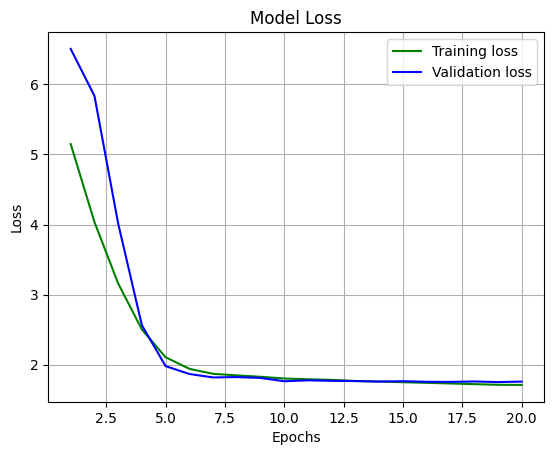

In [20]:
train_loss = two_tower_bert_model_history.history['loss']
val_loss = two_tower_bert_model_history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Movie Embeddings

In [21]:
import pandas as pd
all_data = pd.concat([train_data[:num_train_examples], val_data[:num_val_examples], test_data[:num_val_examples]])
animes = pd.read_csv(f'{data_path}/raw_data/animes_final.csv')

In [22]:
all_anime_ids = all_data['anime_uid'].unique()
all_present_anime_ids = animes[animes['uid'].isin(all_anime_ids)].sort_values(by='popularity')['uid']
all_present_anime_ids

740       1535
7876     11757
3         5114
16       30276
140      22319
         ...  
12503    36619
8579     38043
10528    36352
12335    39215
9454     39560
Name: uid, Length: 3278, dtype: int64

In [23]:

unique_anime_ids = all_present_anime_ids[:2000]

anime_id_dict = {id: i for i, id in enumerate(unique_anime_ids)}

print(f'The length of the unique anime ids is {len(unique_anime_ids)}')

The length of the unique anime ids is 2000


In [24]:
anime_recommendation_input_ids = []
anime_recommendation_token_type_ids = []
anime_recommendation_attention_mask = []
anime_recommendation_uids = []
for anime_id in unique_anime_ids:
    try:
      temp_df = train_data.iloc[:num_train_examples].reset_index()
      anime_idx = temp_df.loc[temp_df['anime_uid'] == anime_id].index[0]
      anime_recommendation_input_ids.append(bert_train_synopsis.input_ids[anime_idx])
      anime_recommendation_token_type_ids.append(bert_train_synopsis.token_type_ids[anime_idx])
      anime_recommendation_attention_mask.append(bert_train_synopsis.attention_mask[anime_idx])
    except IndexError:
      try:
        temp_df = val_data.iloc[:num_val_examples].reset_index()
        anime_idx = temp_df.loc[temp_df[:num_val_examples]['anime_uid'] == anime_id].index[0]
        anime_recommendation_input_ids.append(bert_val_synopsis.input_ids[anime_idx])
        anime_recommendation_token_type_ids.append(bert_val_synopsis.token_type_ids[anime_idx])
        anime_recommendation_attention_mask.append(bert_val_synopsis.attention_mask[anime_idx])
      except IndexError:
        try:
          temp_df = test_data.iloc[:num_val_examples].reset_index()
          anime_idx = temp_df.loc[temp_df[:num_val_examples]['anime_uid'] == anime_id].index[0]
          anime_recommendation_input_ids.append(bert_test_synopsis.input_ids[anime_idx])
          anime_recommendation_token_type_ids.append(bert_test_synopsis.token_type_ids[anime_idx])
          anime_recommendation_attention_mask.append(bert_test_synopsis.attention_mask[anime_idx])
        except IndexError:
          print(f'Could not find index for {anime_id}')
    anime_recommendation_uids.append(anime_id)


In [25]:
input_dataset = tf.data.Dataset.zip(((
    tf.data.Dataset.from_tensor_slices(anime_recommendation_input_ids),
    tf.data.Dataset.from_tensor_slices(anime_recommendation_token_type_ids),
    tf.data.Dataset.from_tensor_slices(anime_recommendation_attention_mask),
    tf.data.Dataset.from_tensor_slices(anime_recommendation_uids)
),)).batch(len(anime_recommendation_uids))

In [26]:
anime_embeddings = anime_model.predict(input_dataset)

1/1 [==============================] - 8s 8s/step


In [ ]:
anime_embeddings[0]

array([1.1428198 , 1.1681492 , 1.1579129 , 0.6477237 , 1.0554812 ,
       0.5759164 , 0.4830284 , 0.8163974 , 0.77127075, 0.79011106,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [ ]:
anime_embeddings[200]

array([1.1428198 , 1.1681492 , 1.1579129 , 0.6477237 , 1.0554812 ,
       0.5759164 , 0.4830284 , 0.8163974 , 0.77127075, 0.79011106,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [ ]:
print(len(anime_embeddings))
print(len(anime_recommendation_uids))

2000
2000


In [ ]:
def tsne_plot(
    embeddings,
    embedding_labels,
    limit = len(unique_anime_ids),
    figsize=(15, 15)
):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(embeddings[:limit])

    # Store x and y values from T-SNE
    x, y = [], []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)
    # Plot x,y values
    for i, label in enumerate(embedding_labels[:limit]):
        plt.scatter(x[i],y[i])
        plt.annotate(i, xy=(x[i], y[i]), ha='right', va='bottom', xytext=(3, 2), textcoords='offset points', )

    plt.show()
    return new_values

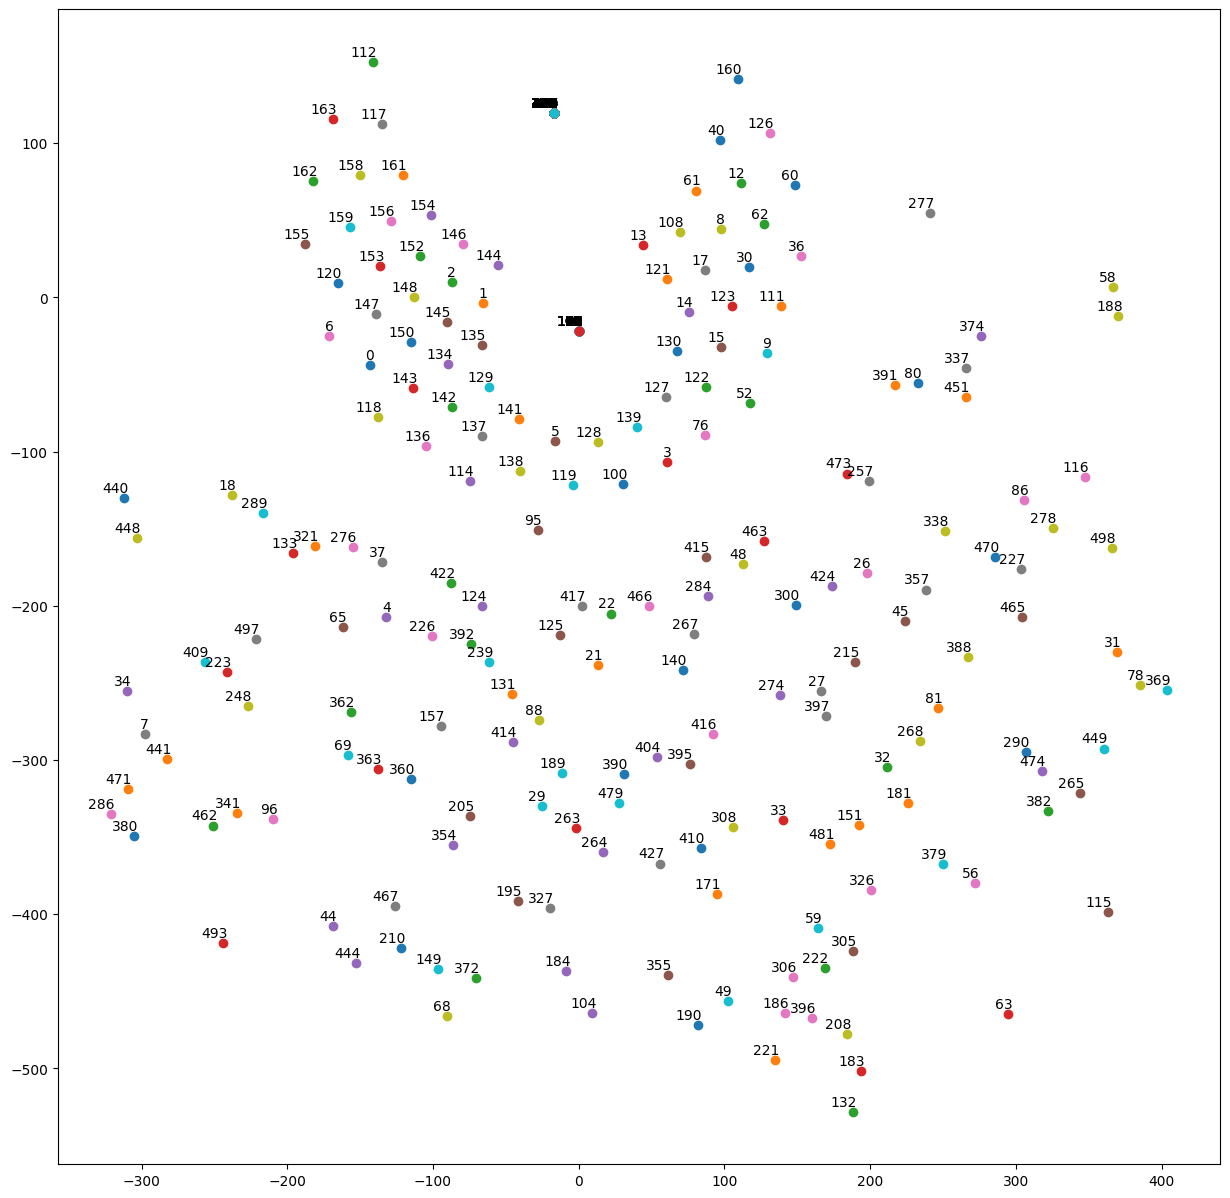

In [ ]:
pca_values = tsne_plot(anime_embeddings, unique_anime_ids, 500)

In [ ]:
movie_idx_1 = 106
movie_idx_2 = 247

In [ ]:
# Select an anime embedding idx
anime_uid_1 = unique_anime_ids[movie_idx_1]
anime_1 = all_data.loc[all_data['anime_uid'] == anime_uid_1].iloc[0]
anime_1

uid                                                          239526
profile                                                 NightsMagic
anime_uid                                                     16009
text              This is my first review, so this review might ...
Overall_score                                                     6
                                        ...                        
Male                                                              1
Non-Binary                                                        0
Unknown                                                           0
birthday_epoch                                                  NaN
age                                                            30.0
Name: 86423, Length: 84, dtype: object

In [ ]:
np.average(all_data.loc[all_data['anime_uid'] == anime_uid_1, 'Overall_score'], axis=0)

In [ ]:
anime_1['synopsis']

In [ ]:
# Select an anime embedding close to anime_1
anime_uid_2 = unique_anime_ids[movie_idx_2]
anime_2 = all_data.loc[all_data['anime_uid'] == anime_uid_2].iloc[0]
anime_2

In [ ]:
np.average(all_data.loc[all_data['anime_uid'] == anime_uid_2, 'Overall_score'], axis=0)

In [ ]:
anime_2['synopsis']

### KNN

In [27]:
n_neighbors = 10

In [28]:
# Fit a KNN Clasiffier

clf = KNeighborsClassifier(n_neighbors=n_neighbors+1)
clf.fit(anime_embeddings, unique_anime_ids)

KNeighborsClassifier(n_neighbors=11)

In [29]:
def anime_recommendations(user_embedding, n_neibhors=n_neighbors):
    _, idxs = clf.kneighbors(user_embedding.reshape(1, -1),  n_neighbors=n_neighbors)
    idxs = idxs.reshape(10,1)

    df_indices = pd.DataFrame(idxs, columns = ['anime_uid'])

    return df_indices.merge(animes.rename(columns={'uid': 'anime_uid'}), on='anime_uid', how='inner')['title']

In [30]:
user_input_dataset = tf.data.Dataset.zip(((
    tf.data.Dataset.from_tensor_slices(x_test.input_ids),
    tf.data.Dataset.from_tensor_slices(x_test.token_type_ids),
    tf.data.Dataset.from_tensor_slices(x_test.attention_mask),
    tf.data.Dataset.from_tensor_slices(user_features_test.values)
),)).batch(len(x_test.attention_mask))

In [31]:
user_embeddings = user_model.predict(user_input_dataset)

1/1 [==============================] - 9s 9s/step


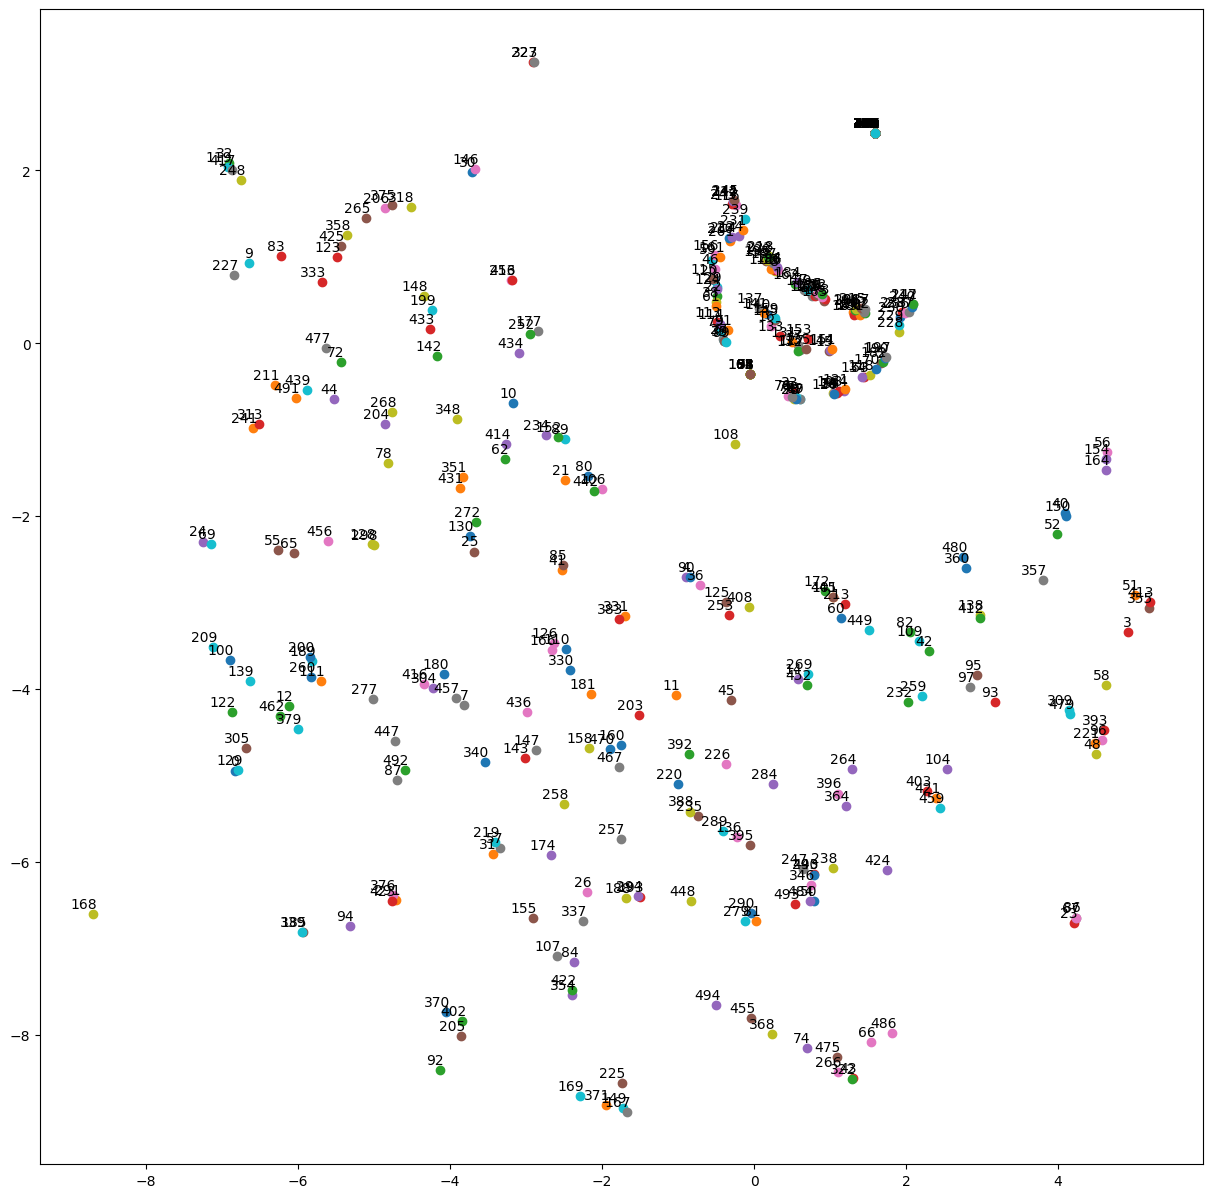

In [ ]:
pca_values = tsne_plot(user_embeddings, unique_user_ids, 500)

In [ ]:
# user_input_dataset = tf.data.Dataset.zip(((
#     tf.data.Dataset.from_tensor_slices(x_test.input_ids),
#     tf.data.Dataset.from_tensor_slices(x_test.token_type_ids),
#     tf.data.Dataset.from_tensor_slices(x_test.attention_mask),
#     tf.data.Dataset.from_tensor_slices(user_features_test.values)
# ),)).batch(len(user_features_test.values))

In [ ]:
# user_embeddings = user_model.predict(user_input_dataset)

In [ ]:
user_embeddings[0]

array([ 0.5347296 ,  0.8251471 ,  0.94129765,  0.8318873 ,  0.74524325,
        0.42467558,  3.0211244 ,  0.9245294 ,  1.1208061 ,  0.8086881 ,
        0.04383557,  0.00586702, -0.04886303, -0.04718563, -0.01023293,
        0.03660649, -0.00586083, -0.03435262, -0.02872683,  0.04739339],
      dtype=float32)

In [ ]:
user_embeddings[1]

array([0.5347296 , 0.8251471 , 0.94129765, 0.8318873 , 0.74524325,
       0.42467558, 3.0211244 , 0.9245294 , 1.1208061 , 0.8086881 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [ ]:
for i in range(30):
  print(f'User {i} Recommendations:')
  print(anime_recommendations(user_embeddings[i].reshape(1,-1)[0]))

User 0 Recommendations:
0                 Phantom The Animation
1             Boku no Sexual Harassment
2                Ryuusei Sentai Musumet
3                        Spectral Force
4                     Asatte no Houkou.
5                Oira Uchuu no Tankoufu
6    Bishoujo Senshi Sailor Moon SuperS
7                   Overman King Gainer
Name: title, dtype: object
User 1 Recommendations:
0    Cowboy Bebop: Tengoku no Tobira
1                             Trigun
2                       Cowboy Bebop
3                     Bouken Ou Beet
Name: title, dtype: object
User 2 Recommendations:
0    Cowboy Bebop: Tengoku no Tobira
1                             Trigun
2                       Cowboy Bebop
3                     Bouken Ou Beet
Name: title, dtype: object
User 3 Recommendations:
0                            Boku no Sexual Harassment
1                                          Megazone 23
2                            Injuu Gakuen La Blue Girl
3             Sensei no Ojikan: Doki Doki 

In [ ]:
user_favorites_id = test_data[['favorites_anime_cleaned']].iloc[user_idx].values[0]
animes[animes['uid'].isin(user_favorites_id)]

,uid,title,synopsis,episodes,members,popularity,ranked,score,Action,Adventure,...,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s
5,37510,Mob Psycho 100 II,"Shigeo ""Mob"" Kageyama is now maturing and unde...",13.0,442310,176,21.0,8.89,1,0,...,0,0,0,0,0,0,0,0,1,0
8,35247,Owarimonogatari 2nd Season,Following an encounter with oddity specialist ...,7.0,189944,573,18.0,8.93,0,0,...,0,0,0,0,0,0,0,0,1,0
245,6774,Kuuchuu Buranko,Many patients with different problems visit th...,11.0,64443,1582,565.0,8.01,0,0,...,0,0,0,0,0,0,0,1,0,0
260,339,Serial Experiments Lain,"Lain Iwakura, an awkward and introverted fourt...",13.0,369716,241,549.0,8.02,0,0,...,0,0,0,0,0,0,1,0,0,0
286,934,Higurashi no Naku Koro ni,Keiichi Maebara has just moved to the quiet li...,26.0,530024,118,519.0,8.04,0,0,...,0,0,0,0,0,0,0,1,0,0
489,34537,Yoru wa Mijikashi Arukeyo Otome,On a mysterious night that seems to last for a...,1.0,56160,1759,313.0,8.21,0,0,...,0,0,0,0,0,0,0,0,1,0
498,20899,JoJo no Kimyou na Bouken Part 3: Stardust Crus...,Years after an ancient evil was salvaged from ...,24.0,403914,214,304.0,8.23,1,1,...,0,0,0,0,0,0,0,0,1,0
574,14719,JoJo no Kimyou na Bouken (TV),"In 1868, Dario Brando saves the life of an Eng...",26.0,579147,102,220.0,8.31,1,1,...,0,0,0,0,0,0,0,0,1,0
611,1210,NHK ni Youkoso!,Twenty-two-year-old college dropout Tatsuhiro ...,24.0,461723,157,182.0,8.36,0,0,...,0,0,0,0,0,0,0,1,0,0
651,13125,Shinsekai yori,Following a sudden outbreak of psychokinesis i...,25.0,514093,125,142.0,8.42,0,0,...,0,0,0,0,0,0,0,0,1,0


### Coverage

In [32]:
selected_test_data = test_data.iloc[:num_val_examples]
unique_profile_ids = selected_test_data['profile_uid'].unique()
print(len(unique_profile_ids))

948


In [33]:
unique_recommendations = set()
unique_recommendation_pairs = set()
total_recommendations = 0
user_recommendations = 0
for i in range(len(user_embeddings)):
  recommendations = anime_recommendations(user_embeddings[i])
  unique_recommendations.update(recommendations.values)
  unique_recommendation_pairs.update([(selected_test_data.iloc[i]['profile_uid'], rec) for rec in recommendations.values])
  total_recommendations += len(recommendations)
  if len(recommendations) > 0:
    user_recommendations += 1



print(f'Unique Recommendations: {len(unique_recommendations)}')
print(f'Unique Recommendation Pairs: {len(unique_recommendation_pairs)}')
print(f'Total Recommendations: {total_recommendations}')
print(f'User Recommendations: {user_recommendations}')

Unique Recommendations: 405
Unique Recommendation Pairs: 7931
Total Recommendations: 8399
User Recommendations: 1000


In [34]:

print(f'Item Coverage: {len(unique_recommendations) / len(unique_anime_ids)}')
print(f'User Coverage: {user_recommendations / num_val_examples}')
print(f'Total Coverage: {len(unique_recommendation_pairs) / (len(unique_anime_ids) * len(unique_profile_ids))}')

Item Coverage: 0.2025
User Coverage: 1.0
Total Coverage: 0.004183016877637131


### Precision and Recall at K

In [35]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, true_r, est in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [36]:
selected_test_datat = test_data.iloc[:num_val_examples]

In [37]:
prediction_input_dataset = tf.data.Dataset.zip(((
    tf.data.Dataset.from_tensor_slices(bert_test_synopsis.input_ids),
    tf.data.Dataset.from_tensor_slices(bert_test_synopsis.token_type_ids),
    tf.data.Dataset.from_tensor_slices(bert_test_synopsis.attention_mask),
    tf.data.Dataset.from_tensor_slices(anime_features_test),
    tf.data.Dataset.from_tensor_slices(x_test.input_ids),
    tf.data.Dataset.from_tensor_slices(x_test.token_type_ids),
    tf.data.Dataset.from_tensor_slices(x_test.attention_mask),
    tf.data.Dataset.from_tensor_slices(user_features_test),
),)).batch(len(x_test.attention_mask))

model_predictions = two_tower_bert_model.predict(prediction_input_dataset)

1/1 [==============================] - 12s 12s/step


In [38]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=7)

precision_at_k = sum(prec for prec in precisions.values())[0][0] / len(precisions)
recall_at_k = sum(rec for rec in recalls.values())[0][0] / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: 0.6925105485232067
Recall@10: 0.7014767932489452
F1@10: 0.6969648350630836


In [39]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=8)

precision_at_k = sum(prec for prec in precisions.values())[0][0] / len(precisions)
recall_at_k = sum(rec for rec in recalls.values())[0][0] / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: 0.5339310829817159
Recall@10: 0.5390295358649789
F1@10: 0.5364681961074687
